# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [17]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://atlassian.design/'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://atlassian.design/
https://atlassian.design/foundations
https://atlassian.design/resources/fonts
https://atlassian.design/foundations/typography
https://atlassian.design/content
https://atlassian.design/patterns
https://atlassian.design/content/language-and-grammar
https://atlassian.design/content/writing-style
https://atlassian.design/resources/logo-library
https://atlassian.design/get-started
https://atlassian.design/license
https://atlassian.design/resources/figma-library
https://atlassian.design/resources/contribution
https://atlassian.design/foundations/iconography
https://atlassian.design/brand
https://atlassian.design/resources/presentation-kit
https://atlassian.design/resources/illustration-library
https://atlassian.design/content/vocabulary
https://atlassian.design/brand/mission
https://atlassian.design/components
https://atlassian.design/brand/promise
https://atlassian.design/foundations/color
https://atlassian.design/brand/personality
https://atlassian.design/resource

https://atlassian.design/components/form
https://atlassian.design/components/flag/flags-provider
https://atlassian.design/components/menu/popup-menu-group
https://atlassian.design/components/onboarding/benefits-modal
https://atlassian.design/components/avatar/avatar-skeleton
https://atlassian.design/components/dropdown-menu/dropdown-item-checkbox
https://atlassian.design/components/popup
https://atlassian.design/components/progress-bar/success-progress-bar
https://atlassian.design/components/image
https://atlassian.design/components/pagination
https://atlassian.design/components/radio
https://atlassian.design/components/menu/heading-item
https://atlassian.design/components/logo
https://atlassian.design/components/motion/resizing-motions
https://atlassian.design/components/banner
https://atlassian.design/components/progress-bar/transparent-progress-bar
https://atlassian.design/components/motion/accessibility
https://atlassian.design/components/code/code-block
https://atlassian.design/co

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [19]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if (parsed.title and parsed.title.string) else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

couldnt extract: https://atlassian.design/foundations
extracted: https://atlassian.design/components/menu Menu - Menu - Components - Atlassian Design System 29 Token, 143
extracted: https://atlassian.design/components/drawer Drawer - Drawer - Components - Atlassian Design System 32 Token, 142
extracted: https://atlassian.design/components/progress-indicator Progress indicator - Progress indicator - Components - Atlassian Design System 32 Token, 154
extracted: https://atlassian.design/components/progress-tracker Progress tracker - Progress tracker - Components - Atlassian Design System 28 Token, 143
extracted: https://atlassian.design/components/avatar-group Badge - Badge - Components - Atlassian Design System 33 Token, 155
extracted: https://atlassian.design/components/page-layout Page layout - Page layout - Components - Atlassian Design System 30 Token, 152
extracted: https://atlassian.design/content/inclusive-writing Inclusive language - Content - Atlassian Design System 3991 Token, 

extracted: https://atlassian.design/content/writing-guidelines/writing-error-messages Writing guidelines - Error message - Content - Atlassian Design System 1024 Token, 4715
extracted: https://atlassian.design/foundations/color-new/data-visualization-color Color new - Data visualization color - Foundations - Atlassian Design System 1670 Token, 7805
extracted: https://atlassian.design/components/motion Motion - Motion - Components - Atlassian Design System 27 Token, 129
extracted: https://atlassian.design/components/menu/skeleton-heading-item Skeleton heading item - Skeleton heading item - Components - Atlassian Design System 25 Token, 114
extracted: https://atlassian.design/license License - Atlassian Design System 1250 Token, 5087
extracted: https://atlassian.design/content/voice-and-tone-principles Voice and tone principles - Content - Atlassian Design System 1557 Token, 7103
extracted: https://atlassian.design/components/inline-message Inline message - Inline message - Components - 

extracted: https://atlassian.design/components Overview - Brand - Atlassian Design System 1144 Token, 5170
extracted: https://atlassian.design/brand/promise Promise - Brand - Atlassian Design System 144 Token, 718
extracted: https://atlassian.design/components/form Form - Form - Components - Atlassian Design System 24 Token, 115
extracted: https://atlassian.design/components/flag/flags-provider Flags provider - Flags provider - Components - Atlassian Design System 29 Token, 141
extracted: https://atlassian.design/components/menu/popup-menu-group Popup menu group - Popup menu group - Components - Atlassian Design System 26 Token, 131
extracted: https://atlassian.design/resources/atlassian-design-system-values-principles Values and principles - Resources - Atlassian Design System 490 Token, 2404
extracted: https://atlassian.design/components/onboarding/benefits-modal Benefits modal - Benefits modal - Components - Atlassian Design System 32 Token, 163
extracted: https://atlassian.design/c

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [20]:
import tiktoken
import jsonlines
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

with_summaries = []
with jsonlines.open('pages_extracted.jsonl', 'r') as pages:
    for page in pages:
        with_summaries.append(page)
    
print('Creating summaries for ' + str(len(list(with_summaries))) + ' pages.')

for page in with_summaries:
    result = model(page['content']['raw'].replace('\n', ' '), num_sentences=3, min_length=60)
    page['summaries'] = dict()
    page['summaries']['sbert'] = ''.join(result)
    print()
    print(page['url'], page['title'], str(len(enc.encode(page['summaries']['sbert']))) + ' Token,', page['summaries']['sbert'])
        
with jsonlines.open('pages_extracted_summaries.jsonl', 'w') as pages:
    pages.write_all(with_summaries)

Creating summaries for 151 pages.

https://atlassian.design/components/menu Menu - Menu - Components - Atlassian Design System 13 Token, A collection of composable menu components that can be used anywhere.

https://atlassian.design/components/drawer Drawer - Drawer - Components - Atlassian Design System 16 Token, A drawer is a panel that slides in from the left side of the screen.

https://atlassian.design/components/progress-indicator Progress indicator - Progress indicator - Components - Atlassian Design System 16 Token, A progress indicator shows the user where they are along the steps of a journey.

https://atlassian.design/components/progress-tracker Progress tracker - Progress tracker - Components - Atlassian Design System 12 Token, A progress tracker displays the steps and progress through a journey.

https://atlassian.design/components/avatar-group Badge - Badge - Components - Atlassian Design System 17 Token, An avatar group displays a number of avatars grouped together in a 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/inclusive-writing Inclusive language - Content - Atlassian Design System 139 Token, The words we choose are the building blocks and the glue that hold our diverse teams together. Don't "nut it out" Do "power through" or "puzzle it out" Reasoning: While some terms may not have origins in offensive language, they have been co-opted over the years and it’s best practice to avoid. Inclusive language related to socio-economic status should: Treat all people fairly, regardless of where they’re from or what they do Avoid negative terms based on where someone’s from or what they do Only be mentioned (without judgment) when relevant to a discussion Don't Bogan or redneck Do Just don’t!

https://atlassian.design/components/datetime-picker Date time picker - Datetime picker - Components - Atlassian Design System 16 Token, A date time picker allows the user to select an associated date and time.

https://atlassian.design/resources/color-palette-resources Color pal

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/color-new Color - Foundations - Atlassian Design System 105 Token, We’ve revamped our color system The original colors remain in use across Atlassian products today. All color design tokens start with the word “color”, followed by the property that it's applied to, such as a background, border, or icon. Refer to the following for guidance on what token to select: A more subtle emphasis to a more bold emphasis, or A more bold emphasis to a more subtle emphasis, or Any other change to emphasis There are no dedicated hovered and pressed tokens for icons.

https://atlassian.design/components/tag-group Tag group - Tag group - Components - Atlassian Design System 14 Token, A tag group controls the layout and alignment for a collection of tags.

https://atlassian.design/components/textarea Text area - Textarea - Components - Atlassian Design System 15 Token, A text area lets users enter long form text which spans over multiple lines.

https://atlassian.de

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/writing-an-info-message Writing guidelines - Info messages - Content - Atlassian Design System 82 Token, Use these messages when you want to provide more information without disrupting someone’s work or requiring them to take action. Get right to the point Say why it's important, then let them get back to work Keep the information useful and don't disrupt your users experience with the message Inform the user about something that might happen or impact them. This flag informs the user they were logged out due to inactivity.

https://atlassian.design/resources/contribution Contribution - Resources - Atlassian Design System 64 Token, Contributions are only open to Atlassians At the moment, we're only accepting contributions from internal Atlassians. Why large contributions are currently not accepted Considering a design system component or pattern takes time. To avoid being a bottleneck, we’d love to be involved in your product impleme

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/date-and-time-guideline Writing guidelines - Date and time - Content - Atlassian Design System 147 Token, When you’re working with engineers, all they need is the time and date format length, and the i18n library API will format the date accordingly based on the locale signals Atlassian provides. Spell out the month using abbreviations Use numerals for the day and the year We recommend using the following pattern in most product copy if your context allows for it Do Sep 14, 2006 When you need to leave out either the day or year, where possible, spell out the month in full. To do this use the following formats MMM dd, yyyy HH:mm dd, HH:mm It’s important that you express date and time information as you would speak in conversation when the situation allows for it.

https://atlassian.design/components/menu/section Section - Section - Components - Atlassian Design System 0 Token, 

https://atlassian.design/components/icon-object Icon obj

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/components/radio/radio-group Radio group - Radio group - Components - Atlassian Design System 16 Token, A radio group presents a list of options where only one choice can be selected.

https://atlassian.design/brand/values Values - Brand - Atlassian Design System 60 Token, Information is open internally by default and sharing is a first principle. Passion and urgency infuse everything we do, alongside the wisdom to consider options fully and with care. All Atlassians should have the courage and resourcefulness to spark change – to make better our products, our people, our place.

https://atlassian.design/components/tag Tag - Tag - Components - Atlassian Design System 11 Token, A tag labels UI objects for quick recognition and navigation.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/patterns/forms Forms - Patterns - Atlassian Design System 67 Token, Forms are used to get information and guide people with minimal fuss. Designing forms well requires making decisions about structure, sequence, interface elements, field labels, help, and feedback. Exceptions to this are single-page forms, flags, cards and section messages where buttons are left aligned; with the primary button on the left.

https://atlassian.design/components/atlassian-navigation Atlassian navigation - Atlassian navigation - Components - Atlassian Design System 0 Token, 


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/writing-a-warning-message Writing guidelines - Warning message - Content - Atlassian Design System 72 Token, A warning message, different from error messages, appears before someone takes an action to indicate a significant change or potential loss of data. Include: the reason for the warning and the potential problem, how someone should act, and what happens if they don’t act. Give clear, concise advice on which path to take and describe and provide alternatives if possible.

https://atlassian.design/components/checkbox Checkbox - Checkbox - Components - Atlassian Design System 23 Token, A checkbox is an input control that allows a user to select one or more options from a number of choices.

https://atlassian.design/components/flag/auto-dismiss-flag Auto dismiss flag - Auto dismiss flag - Components - Atlassian Design System 0 Token, 

https://atlassian.design/components/progress-bar Progress bar - Progress bar - Components - Atlas

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/design-tokens Spacing - Foundations - Atlassian Design System 61 Token, Design tokens are the new way to apply color, elevations, and other visual styles in Atlassian product experiences. Design in one theme, get the rest for free:Our design tokens are mapped to values for light and dark themes. Do Use design tokens with names and descriptions that fit your specific situation.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/patterns/first-impressions/new-or-updated-feature First impressions - New or updated feature - Patterns - Atlassian Design System 57 Token, The new or updated feature can consist of small or medium changes. For features that provide shortcuts for power users or otherwise improve the way they work, consider introducing a spotlight after recognizing a pattern of repeated behavior. In this example, an admin moves an issue from to do to in progress.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/empty-state Writing guidelines - Empty state - Content - Atlassian Design System 66 Token, An empty state message appears after someone has completed a task or workflow, or has cleared all data associated with certain functionality. Use the heading to describe the empty state or as an opportunity to tell people what they can do. Messages that appear after a bigger, optimistic action can be more playful, for example, a modal dialog.

https://atlassian.design/components/menu/button-item Button item - Button item - Components - Atlassian Design System 0 Token, 

https://atlassian.design/components/onboarding Onboarding (spotlight) - Onboarding - Components - Atlassian Design System 18 Token, An onboarding spotlight introduces new features to users through focused messages or multi-step tours.

https://atlassian.design/components/icon/custom-icon Custom icon - Custom icon - Components - Atlassian Design System 15 Token, A custom icon is 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/writing-error-messages Writing guidelines - Error message - Content - Atlassian Design System 88 Token, An error message, different from a warning message, appears after someone has taken an action. Stick to the most likely cause or the simplest solution in the first sentence of the error message and offer an alternative backup solution in the second sentence in case the error keeps occurring (for example, contacting support). Do Don't For dead ends, start with something short but kind, and add context or other details only if the error will reoccur.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/color-new/data-visualization-color Color new - Data visualization color - Foundations - Atlassian Design System 62 Token, This is a preview of our new color and theming system, powered by design tokens Expect frequent changes as we iterate over the coming months. Token Description color.chart.brand Our primary color for data visualization. For the full list of chart design tokens and their values, see our design token reference list.

https://atlassian.design/components/motion Motion - Motion - Components - Atlassian Design System 0 Token, 

https://atlassian.design/components/menu/skeleton-heading-item Skeleton heading item - Skeleton heading item - Components - Atlassian Design System 0 Token, 


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/license License - Atlassian Design System 238 Token, Subject to the terms of this License Agreement, Atlassian Pty Lty ( “Atlassian”) grants you a limited, worldwide, royalty-free, non-assignable, and non-exclusive license to use the Atlassian Design Guidelines ( “ADG”) solely in connection with creating, testing, and distributing plugins, extensions, add-ons or other software products or services that interoperate or are integrated with Atlassian’s software and hosted products ( “Add-Ons”). THE ABOVE WARRANTY DISCLAIMERS AND LIMITATIONS OF LIABILITY APPLY TO THE MAXIMUM EXTENT PERMITTED BY LAW, BUT YOU MAY HAVE OTHER STATUTORY RIGHTS, WHICH THIS AGREEMENT CANNOT CHANGE. You agree to indemnify, defend and hold Atlassian harmless from and against any and all claims, costs, damages, losses, liabilities and expenses (including reasonable attorneys’ fees and costs) arising out of any claim relating to (a) your Add-Ons, (b) your use of the ADG or (c) your breach of

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/voice-and-tone-principles Voice and tone principles - Content - Atlassian Design System 133 Token, We use the Atlassian voice across all of our properties and products. Person is feeling confident, interested, trust, anticipation Examples: power users, admins, everyday users Related design principles In product we use this principle in first impressions, benefits modal, and modal dialogs When something requires an action from the user When there is an educational opportunity When there is a social opportunity - let them known best practices or how we do it! Guide people by revealing information gracefully, for example: “you are on the right path” “you are not alone” reminders about team building and the chaos of projects Write in an upbeat, friendly way.

https://atlassian.design/components/inline-message Inline message - Inline message - Components - Atlassian Design System 18 Token, An inline message lets users know when important information is avai

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/iconography Iconography - Foundations - Atlassian Design System 91 Token, Icons should be used in a purposeful manner to maximize comprehension and reduce cognitive load when you need to call attention to a particular action, command, or section. As a general rule, icons should be used in combination with meaningful text to support users progressing through the product in an accessible manner. There are three types of icons in our design system: Standard sized icons are used as visual representations of common actions and commands to provide additional context and enhance usability.

https://atlassian.design/components/dynamic-table Dynamic table - Dynamic table - Components - Atlassian Design System 22 Token, A dynamic table displays rows of data with built-in pagination, sorting, and re-ordering functionality.

https://atlassian.design/components/code Code - Code - Components - Atlassian Design System 12 Token, Code highlights short strings of co

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/logos Logos - Foundations - Atlassian Design System 124 Token, In everything we do, we aim to bring focus and clarity to teams without distracting, so our logos and symbols are direct, clear, and impactful. Contained product logo icons offer more flexibility than full logos because they are removed from the wordmark and allow accompanying information to live alongside the logomark in a way that keeps the information visually separate from the logo. Attribution lockups allow us to unify our product brands with the Atlassian wordmark and ensure that customers connect the dots between Atlassian and our land products (Confluence, Compass, Trello, Jira, and all Jira family products).

https://atlassian.design/components/dropdown-menu Dropdown menu - Dropdown menu - Components - Atlassian Design System 15 Token, A dropdown menu displays a list of actions or options to a user.

https://atlassian.design/components/avatar/avatar-status Avatar status - Avata

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/resources Overview - Resources - Atlassian Design System 68 Token, Resources A collection of tools, kits, plugins and guides to help simplify the creation process for our users. Design principles Our Figma libraries contain the latest foundations, components, and patterns for designing and building Atlassian products. Logo library Our complete kit of presentation assets in Keynote and PowerPoint includes graphic assets, sample decks, and more.

https://atlassian.design/foundations/color-new/color-palette-new Language and grammar - Content - Atlassian Design System 71 Token, These are the values behind our new color system These colors are not yet rolled out to customers, but will be as we roll out design tokens and theming. Neutral100 in the light neutral ramp should equate to DarkNeutral100 in the dark neutral ramp. Saturated colors are also easy to convert from a light theme to a dark theme using symmetry.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/get-started/design Design - Get started - Atlassian Design System 147 Token, Use the following guidelines to make consistent and distinct Atlassian product designs: Foundations: Our colors, grid, and basic visual styles Components: All of our UI elements explained, including design usage guides Content: Guidelines for written content across Atlassian products Patterns: Larger experiences made of smaller components and styles Our Figma tooling contains the latest foundations, components, and patterns for designing and building Atlassian products. If you cannot find what you need within the Atlassian Design System, check the following resources: More Atlassian components in Atlaskit Industry best practices for accessibility and user experience Atlassian employees can contact our team for help. If you need to move your designs from old colors to design tokens, please see our migration guide.

https://atlassian.design/components/table-tree Table tree - Table tree 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/writing-guidelines/writing-guidelines/date-and-time-guideline Writing guidelines - Date and time - Content - Atlassian Design System 175 Token, A note for Content Designers When you’re working with engineers, all they need is the time and date format length, and the i18n library API will format the date accordingly based on the locale signals Atlassian provides. Long date Use full date in cards, bylines, and anywhere else space or your design allows for it: Use numerals for the day Spell out the month and day of the week in words Give the full four-digit year, not a two-digit abbreviation Don’t use ordinal numbers, for example, 1st, 2nd, 3rd, etc. To do this use the following formats MMM dd, yyyy HH:mm dd, HH:mm Relative date and time It’s important that you express date and time information as you would speak in conversation when the situation allows for it.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/typography Typography - Foundations - Atlassian Design System 214 Token, Download our fonts by going to go/fonts (Atlassian employees only) We use our custom font, Charlie Sans, for almost everything brand and marketing — from banner ads to billboards. Use in moderation.| |Text size h800|Basic properties |Font size: 29px| |Font weight: 600 / semibold| |Character spacing: -0.01em| |Color: N800| UI properties |Line height: 32px| |Margin top: 40px| Long form properties |Line height: 32px| |Margin top: 48px| Use for |Empty states and feature introductions. Our service sites use a mixture of both marketing and product typography and is assessed on a case-by-case basis depending on the following considerations: Atlassian messaging vs. user-generated or modified content editorial content vs. technical content brand marketing visual styles vs. product UI visual styles consistency across sites vs. one-off solutions Please work directly with the Creative & D

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/spacing https://atlassian.design/foundations/spacing 69 Token, This is a preview of our new spacing scale Expect frequent changes as we iterate over the coming months. Using consistent spacing around elements lends them a visual similarity that helps the user understand their semantic relationship. Do Adjust spacing to create visual balance Don't Use standard spacing without considering its alignment with other elements Learn more about Typography Was this page helpful?

https://atlassian.design/components/empty-state Empty state - Empty state - Components - Atlassian Design System 20 Token, An empty state appears when there is no data to display and describes what the user can do next.

https://atlassian.design/components/page/grid Grid - Grid - Components - Atlassian Design System 17 Token, Grid controls layout and spacing on a page and serves as a wrapper for Grid columns.

https://atlassian.design/components/section-message Section message - Se

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/content/language-and-grammar https://atlassian.design/content/language-and-grammar 127 Token, Yes:Jira Service Desk, jira.atlassian.com, developer.atlassian.com No:JSD, JAC, DAC, CD's, 1980's, i.e., e.g. Yes:Administrators control user access to Atlassian Cloud applications. Em dashes can help avoid confusion when the phrase being set apart contains several commas, such as a mid-sentence list. No:To learn more, see the 2008 IT Unplugged report No: In your project, select Settings> Request types Use lists to draw the reader's eye and make items easier to scan and follow.

https://atlassian.design/components/page Page - Page - Components - Atlassian Design System 16 Token, A page layout organizes sections on a page using a grid and grid columns.

https://atlassian.design/components/modal-dialog Modal dialog - Modal dialog - Components - Atlassian Design System 18 Token, A modal dialog displays content that requires user interaction, in a layer above the page.

h

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/patterns/messages Messages - Patterns - Atlassian Design System 64 Token, Message content can include authentication, information, confirmation, warnings, and error messages. It is important to specify which type of content the message falls under in order to choose the relevant color and correct icon. They should only be used for critical system-level messaging (warnings and errors) about loss of data or functionality.

https://atlassian.design https://atlassian.design 63 Token, Design, develop, deliver Use Atlassian’s end-to-end design language to create simple, intuitive and beautiful experiences. Explore our brand Our mission is to unleash the potential in every team. Contributing to our design system – a library of content, design, tooling, and code for products.

https://atlassian.design/patterns/first-impressions/new-experience First impressions - New experience - Patterns - Atlassian Design System 59 Token, A new experience can include medium or large 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/illustrations Illustrations - Foundations - Atlassian Design System 144 Token, Our illustrations range from detailed hero images down to in-product spot images with a consistent narrative of practicality, optimism, and friendliness used throughout. Illustrations can: make complex ideas more accessible represent our brand - personality, voice, and platform - in an efficient and clear way scale up or down depending on the context affect tone and speak directly to users depending on the job to be done and the user's emotional state help to tell stories and thoughtfully convey ideas - they should not be used as decoration or without consideration We use illustration across marketing touchpoints to support a cohesive, clear, and consistent story from start to finish. Our illustration style takes larger-than-life achievements and makes them human and relatable.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/elevation Elevation - Foundations - Atlassian Design System 171 Token, This is a preview of our new color and theming system, powered by design tokens Expect frequent changes as we iterate over the coming months. Using elevation.surface.sunken vs color.background.neutral Although elevation.surface.sunken and color.background.neutral tokens may appear similar in light mode, they behave differently in dark mode. |Z-index||Example usage||Elevation level| |100||None||None| |200||Atlassian navigation||Default| |300||Inline dialog||Overlay| |400||Popup||Overlay| |500||Blanket||None| |510||Modal||Overlay| |600||Flag||Overlay| |700||Spotlight||Overlay| |800||Tooltip||None| Learn about the basics of design tokens.

https://atlassian.design/components/select Select - Select - Components - Atlassian Design System 17 Token, Select allows users to make a single selection or multiple selections from a list of options.

https://atlassian.design/components/motion/

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/components Overview - Brand - Atlassian Design System 55 Token, Components Components are the reusable building blocks of our design system. Dropdown menu A dynamic table displays rows of data with built-in pagination, sorting, and re-ordering functionality. Beta Image An inline dialog is a pop-up container for small amounts of information.

https://atlassian.design/brand/promise Promise - Brand - Atlassian Design System 85 Token, Our Our teamwork solutions enable an open way of working, freeing the flow of information, deepening interpersonal and organizational connections, and enhancing trust, which increases the limits of what teams are able to achieve together. Just as everything we do should be in support of our mission, everything we do should fulfill our promise. Other questions you might ask are: How does your solution help teams increase the cross-flow of information and build trust?

https://atlassian.design/components/form Form - Form - Components -

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt


https://atlassian.design/content/writing-style Writing style - Content - Atlassian Design System 74 Token, We speak our minds by quickly offering solutions that will be useful to our users, right now. Weave a consistent story across our fabric and be diligent about vocabulary across all messaging by being brand conscious across products to create a seamless flow across all the things. Let people know that they can jump in and start working expecting to find a dependable experience across all the things.

https://atlassian.design/components/dropdown-menu/dropdown-item-checkbox Dropdown item - Dropdown item - Components - Atlassian Design System 16 Token, A dropdown item checkbox lets users select items from a list of options.

https://atlassian.design/components/popup Popup - Popup - Components - Atlassian Design System 0 Token, 

https://atlassian.design/components/progress-bar/success-progress-bar Success progress bar - Success progress bar - Components - Atlassian Design System 11 T

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/accessibility Accessibility - Foundations - Atlassian Design System 88 Token, Products and web properties need to be accessible to everyone, including those with vision, hearing, cognitive or motor impairments. When creating an application, check if a keyboard can be used to: navigate perform the same tasks as people who use a mouse locate where you are on the page tell where the keyboard focus is Keyboard focus follows the page as the eye would scan it. Don't Don't use low contrast color combinations that fail AA compliance.

https://atlassian.design/brand https://atlassian.design/brand 63 Token, Brand Our brand reflects who we are and how we want our users to feel when they use our products. Personality Our promise is that our tools and practices will help teams work better together in an agile, open, and scalable way. Promise Our values reflect the spirit with which an Atlassian works to fulfill our promise.

https://atlassian.design/foundations

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://atlassian.design/foundations/color Color - Foundations - Atlassian Design System 147 Token, A new color system, design tokens, and themes are coming soon Design tokens and theming will soon change how we use color, opacity, and elevations. When used in conjunction with our primary palette, these colors make every moment feel on-brand and every interaction informative. R300 - Poppy surprise FF5630 255, 86, 48 Y300 - Golden state FFAB00 255, 171, 0 G300 - Fine pine 36B37E 54, 179, 126 T300 - Tamarama 00B8D9 0, 184, 217 P300 - Da' juice 6554C0 101, 84, 192 The extended palette consists of all the useable tints and shades of each color in the palette.

https://atlassian.design/brand/personality Personality - Brand - Atlassian Design System 45 Token, Not everyone will agree with everything we say – and that's ok. We are clear and direct, acknowledge the hard truths… but are not cocky. How might our personality traits help diffuse a moment of frustration or pain?


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [21]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

with_sections = []
with jsonlines.open('pages_extracted_summaries.jsonl') as pages:
    for page in pages:
        outputs = []
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
        df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
        df = df[df.tokens>40]
        df = df.drop_duplicates(['title','heading'])
        df = df.reset_index().drop('index',axis=1) # reset index
        df.head()

        result = df.to_json(orient="records")
        parsed = json.loads(result)
        page['sections'] = parsed
        
        with_sections.append(page)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(with_sections)
    
print('Extracted sections for ' + str(len(with_sections)) + ' pages.')

Extracted sections for 151 pages.


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-06 17:19:23,197 - top2vec - INFO - Pre-processing documents for training
2023-03-06 17:19:23,252 - top2vec - INFO - Creating joint document/word embedding


138 documents added for topic generation.


2023-03-06 17:19:32,269 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-06 17:19:33,832 - top2vec - INFO - Finding dense areas of documents
2023-03-06 17:19:33,837 - top2vec - INFO - Finding topics



2 topics discovered.

Top topic returned for keyword search "component":

Top 10 words by similarity to keyword "component":
an 0.5287848820024266
someone 0.513862302238751
admin 0.4799357181127603
scannable 0.4715422751770747
educational 0.4406859242790909
count 0.412692482684978
depend 0.407066437281592
choose 0.4056444343896471
after 0.4029847541104781
limit 0.401435925319484

Top 10 sections / topic
Topic 0
Document: 117, Score: 0.5069384574890137
-----------
Inline edit - Inline edit - Components - Atlassian Design System Summary **Was this page helpful?**
We use this feedback to improve our documentation.
An inline edit displays a custom input component that switches between reading and editing on the same page.
**Was this page helpful?**
We use this feedback to improve our documentation.
-----------

Document: 22, Score: 0.49602481722831726
-----------
Presentation kit - Resources - Atlassian Design System Summary Our presentation kits have moved to go/presentation-palace (only

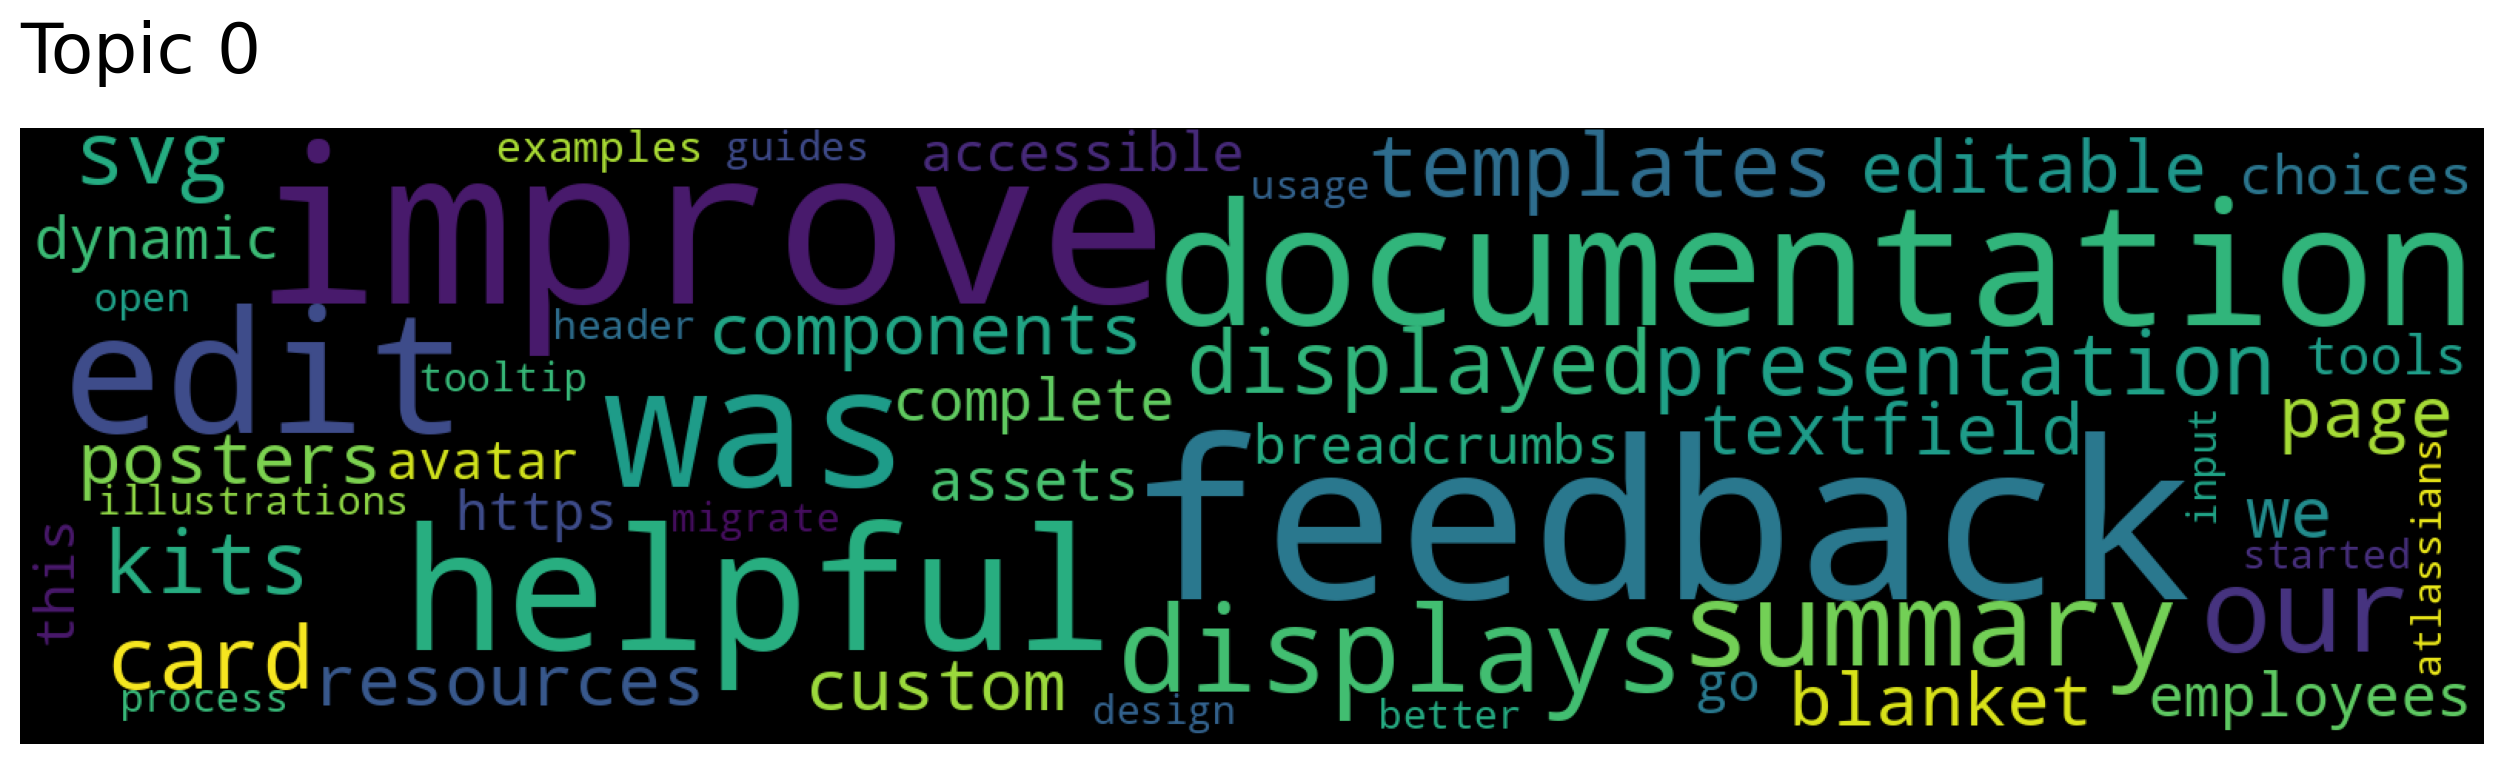

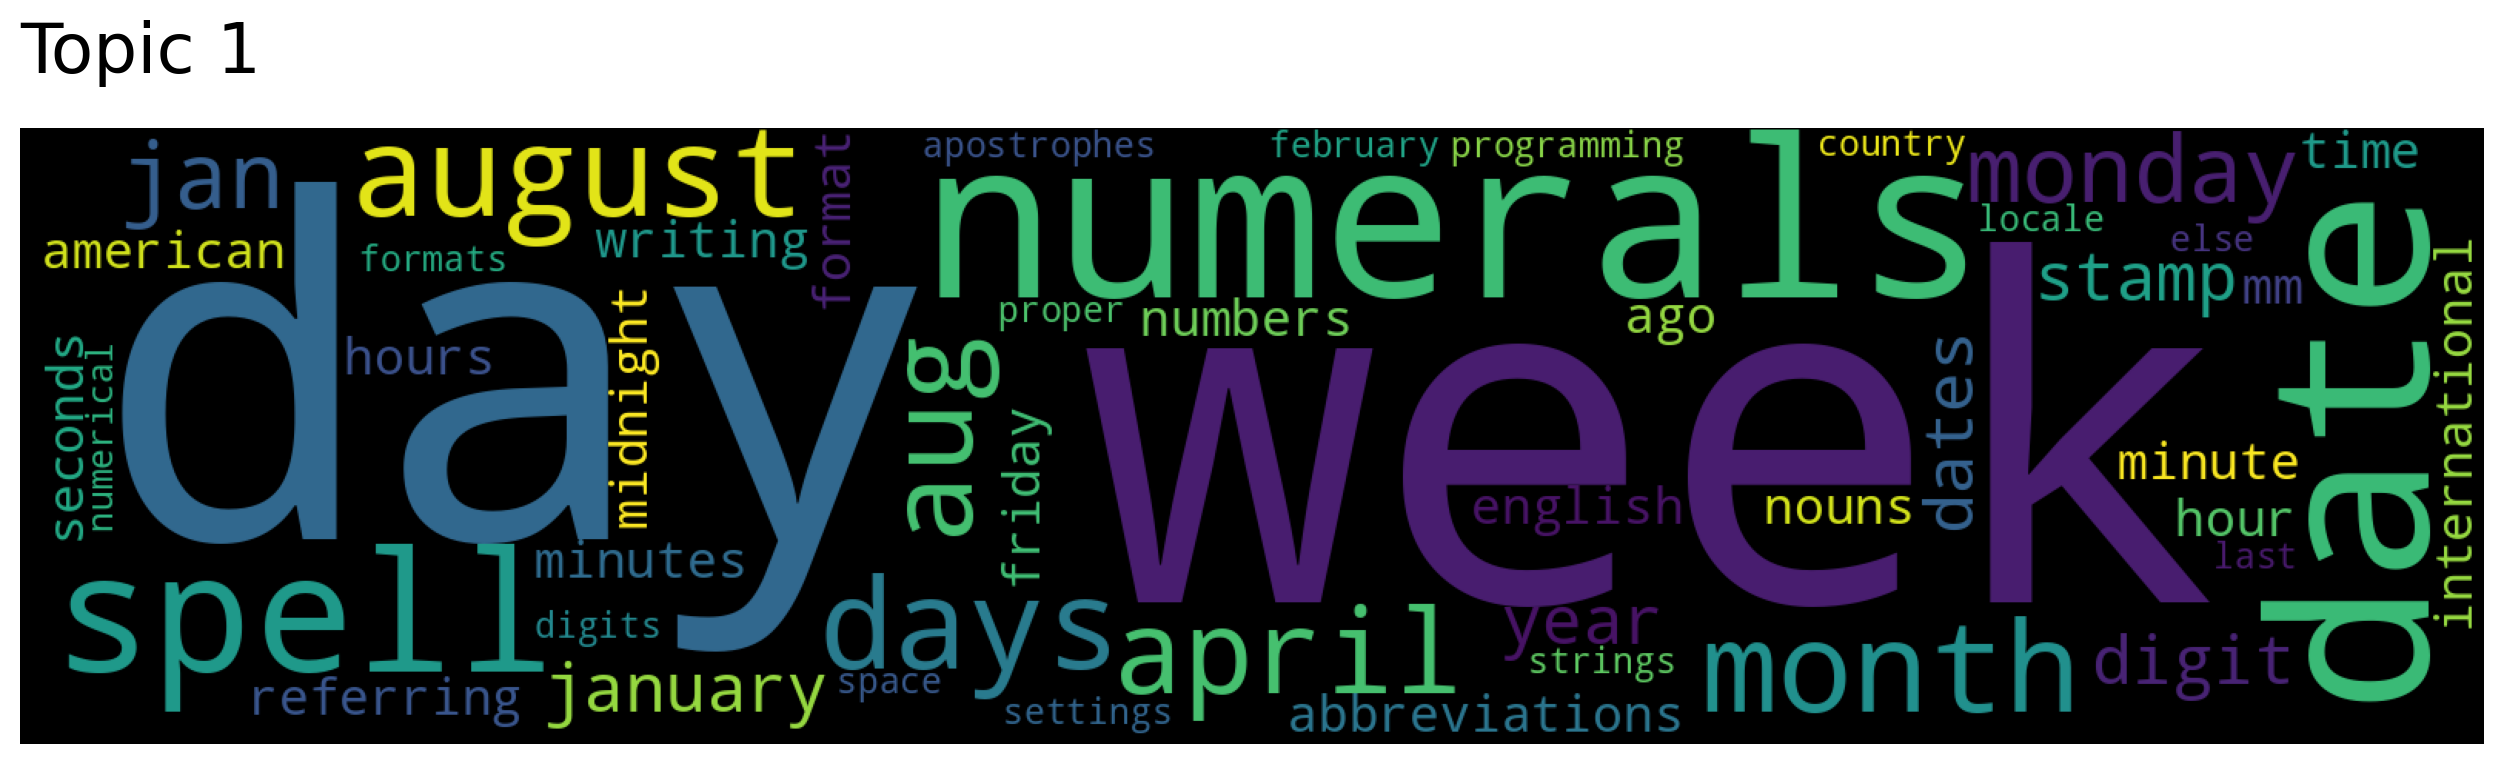

In [22]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        for section in page['sections']:
            documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top topic returned for keyword search "component":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["component"], num_topics=2)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "component":')
words, word_scores = model.similar_words(keywords=["component"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections / topic')
for topic in topic_nums:
    print('Topic ' + str(topic))
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic, num_docs=10)
    for doc, score, doc_id in zip(documents, document_scores, document_ids):
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()
  
print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["component", "create"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [23]:
import json
import gzip
import os
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder, util

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")

#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def getSectionContent(section):
    return section['title'] + ': ' + section['content']

passages = []
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        #Add all paragraphs
        passages.extend(map(getSectionContent, page['sections']))

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

Passages: 138


Batches: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


In [24]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

import string
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
from tqdm.autonotebook import tqdm

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 9229.86it/s]


In [25]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))

In [26]:
search("What is accessibility?")

Input question: What is accessibility?
Top-5 lexical search (BM25) hits
	3.669	Iconography - Foundations - Atlassian Design System: Icons should be used in a purposeful manner to maximize comprehension and reduce cognitive load when you need to call attention to a particular action, command, or section. Use them infrequently – if you’re questioning an icon’s use, it probably doesn’t need to be used at all. Our icons are designed with our brand personality baked in, aiming to balance our human side with function. As a general rule, icons should be used in combination with meaningful text to support users progressing through the product in an accessible manner. However, avoid aria-labels if you are rendering the icon with visible text to prevent accessibility label duplication. There are few widely recognized icons, so whenever possible, use a label or supporting text to ensure its meaning is understood. In this case, an aria-label will be used for the icon. Find out more about writing m

In [27]:
search('Why choose React for your frontend framework?')

Input question: Why choose React for your frontend framework?
Top-5 lexical search (BM25) hits
	3.116	Writing guidelines - Warning message - Content - Atlassian Design System: A warning message, different from error messages, appears **before** someone takes an action to indicate a significant change or potential loss of data. It draws their attention to a potential problem that may or may not require an action on the user’s part. When crafting warning messages, remember that most people scan text instead of reading everything. Make every word count and avoid irrelevant details. Titles are optional depending on the component you choose. Include an informative, scannable title. Try and imagine people trying to understand what’s happening by reading the title on its own. Avoid explaining what to do. Limit titles to three to four words where possible, excluding “an”, “a”, or “the”. The character count will depend on the component you choose. Write in sentence case with appropriate punctua